# Comparing MMM approaches for toy models

The goal of this notebooks it to try a few different approaches and modules and gain some insights into what can be the potential differences.

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

import statsmodels.api as sm


from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM

In [2]:
warnings.filterwarnings("ignore")

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

Number of observations: 179


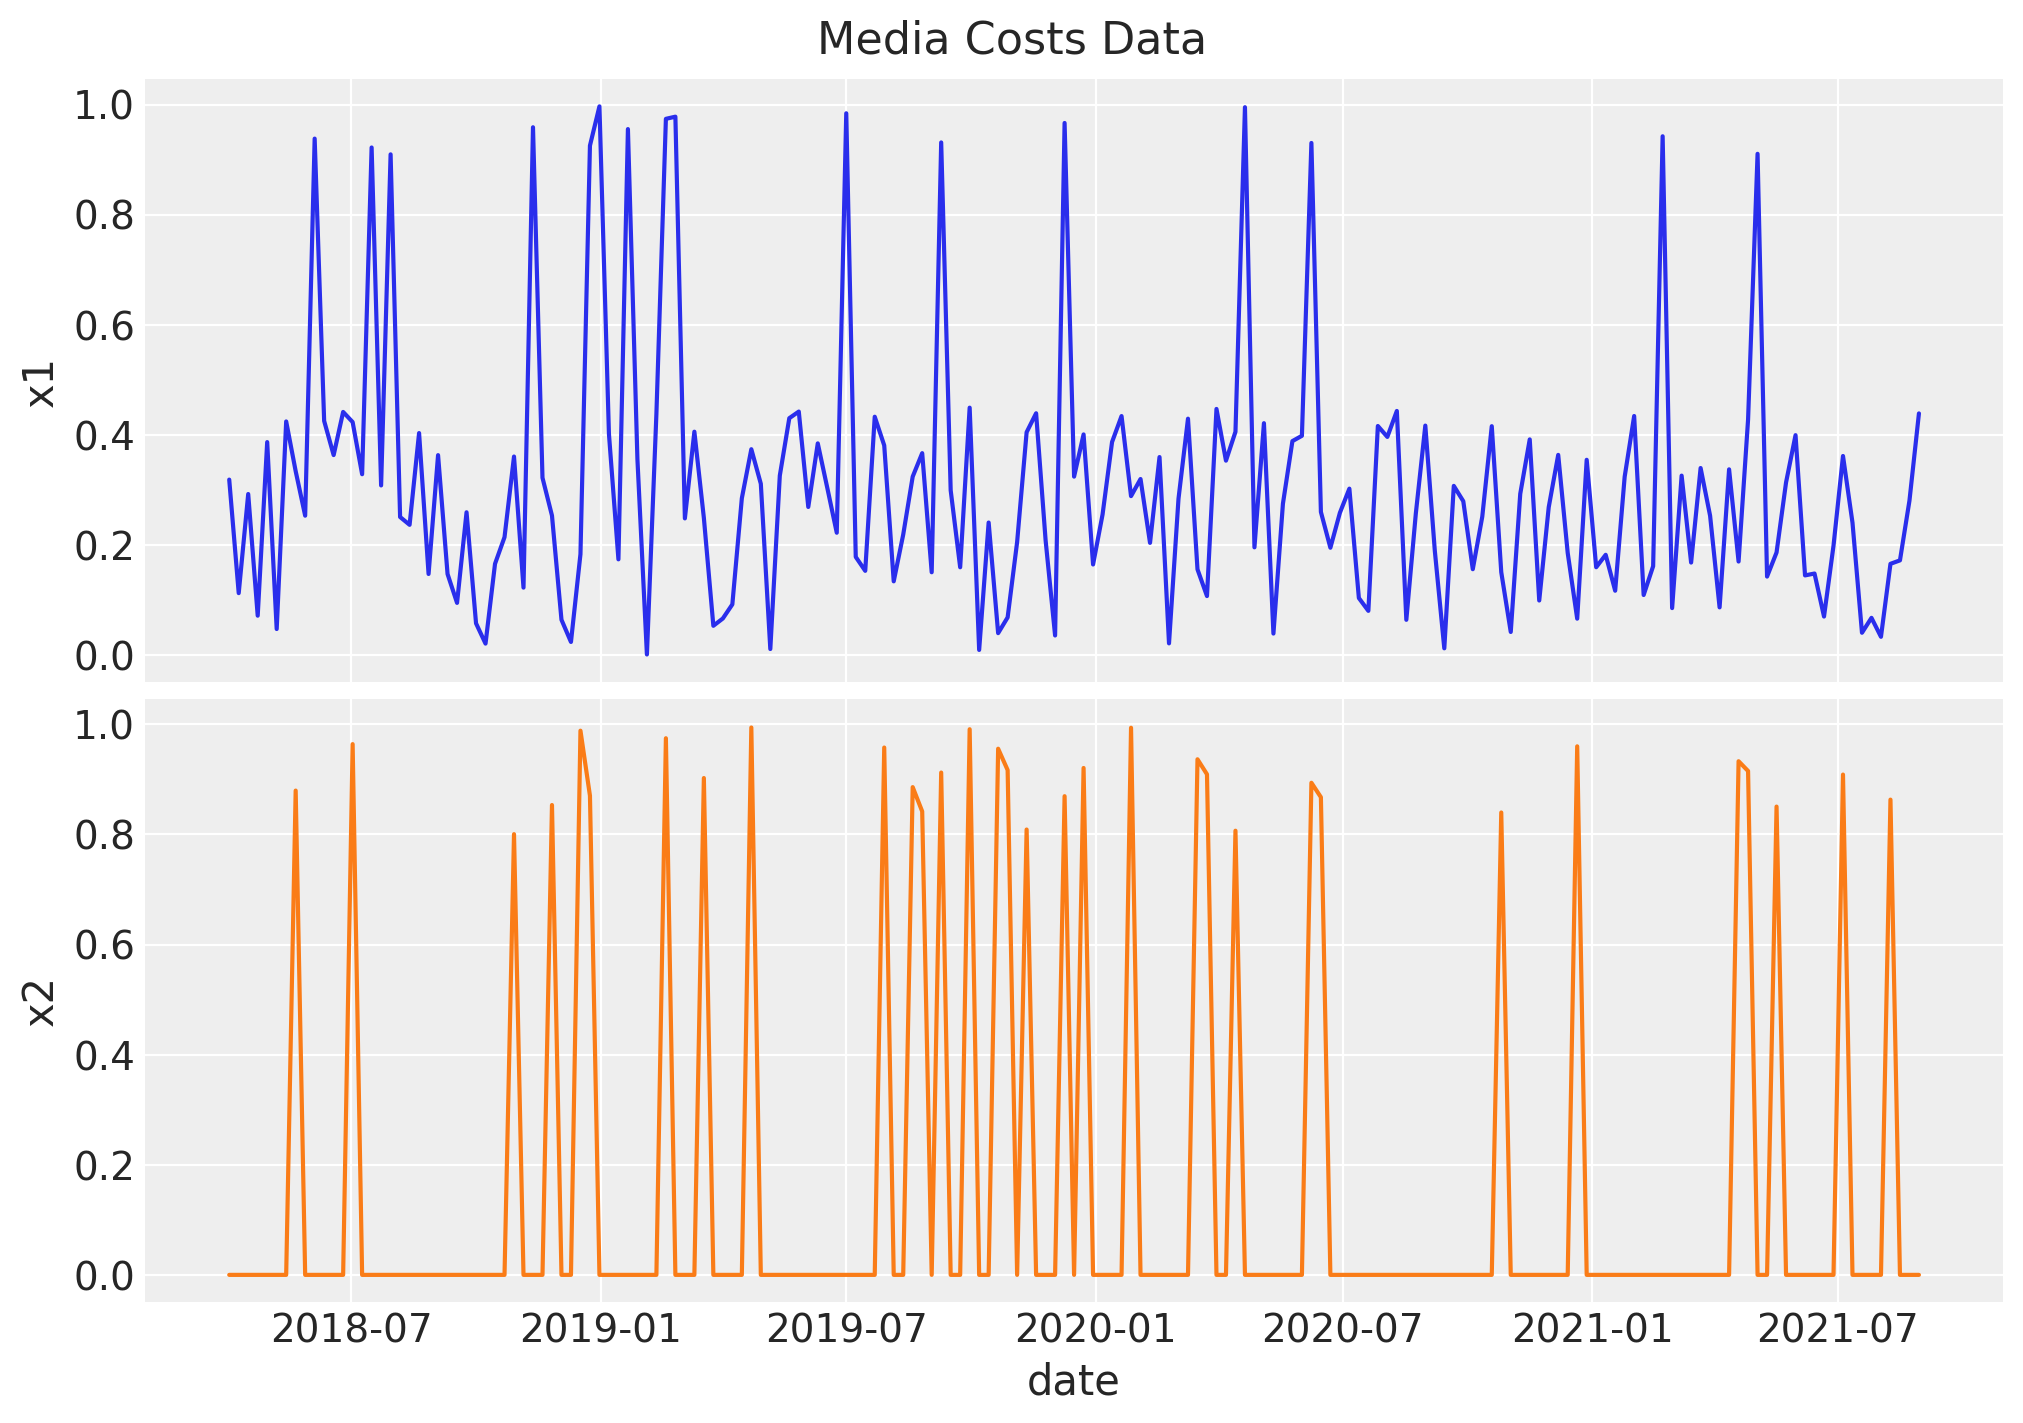

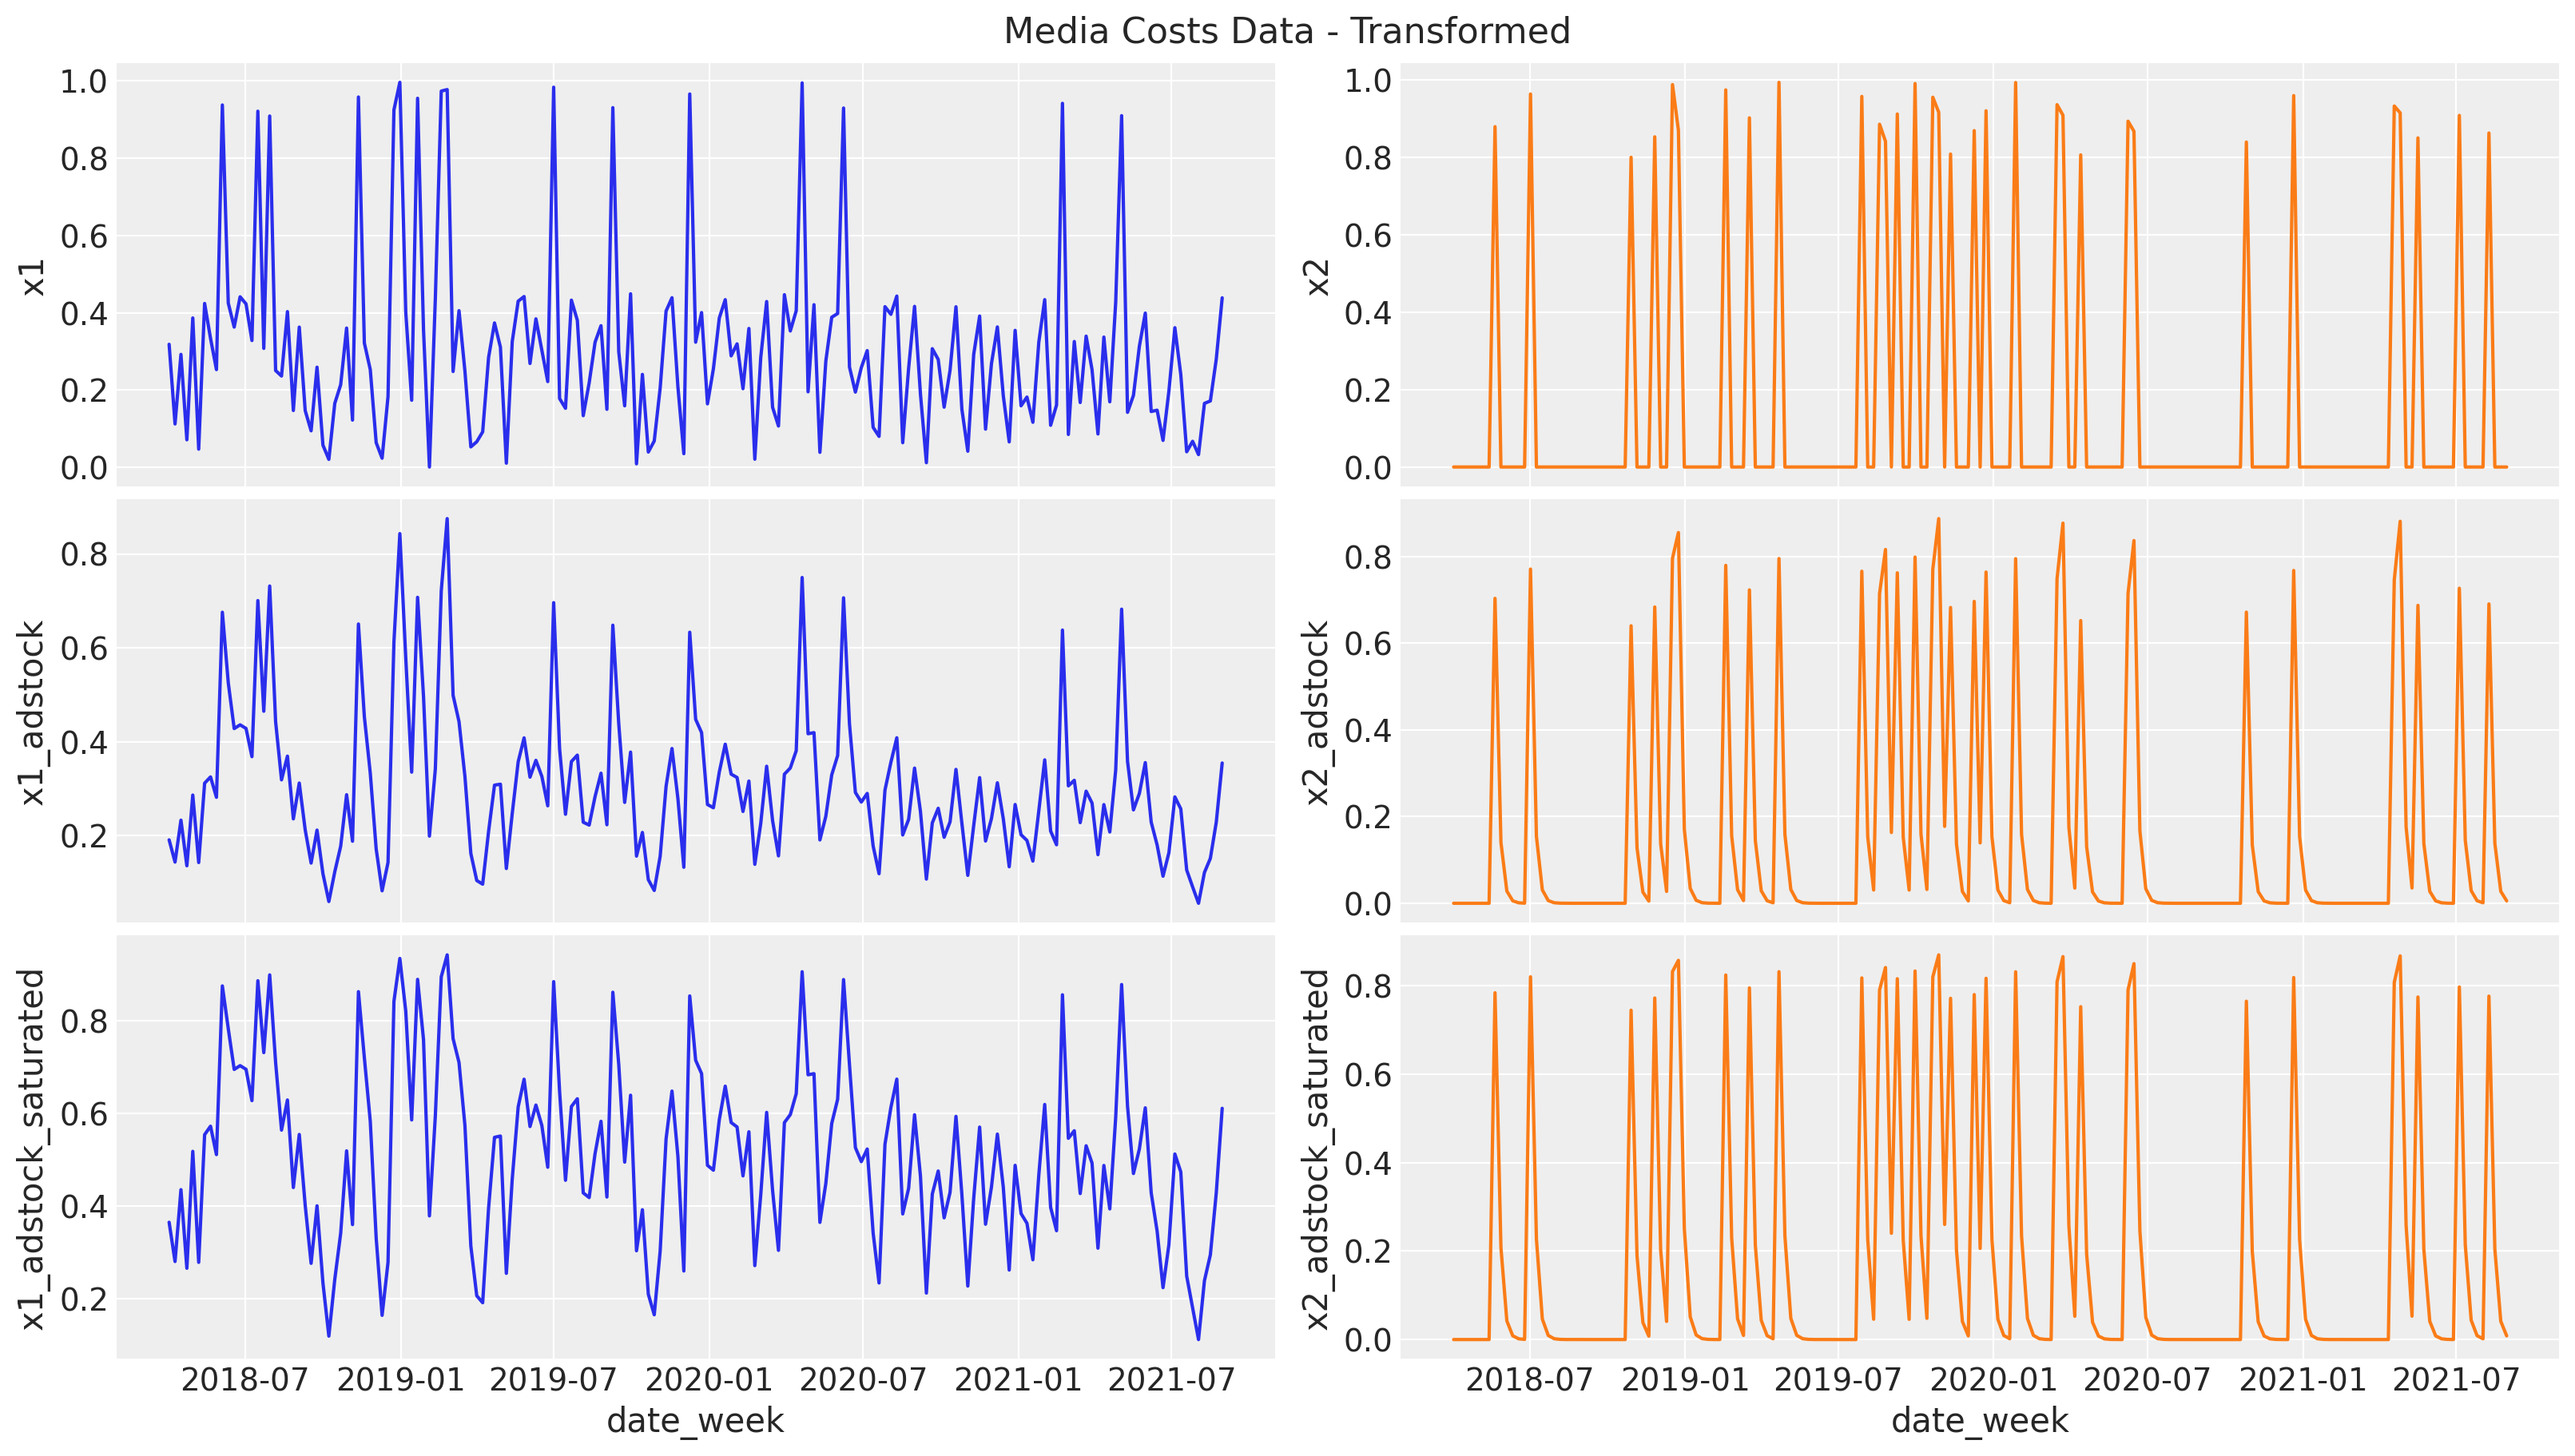

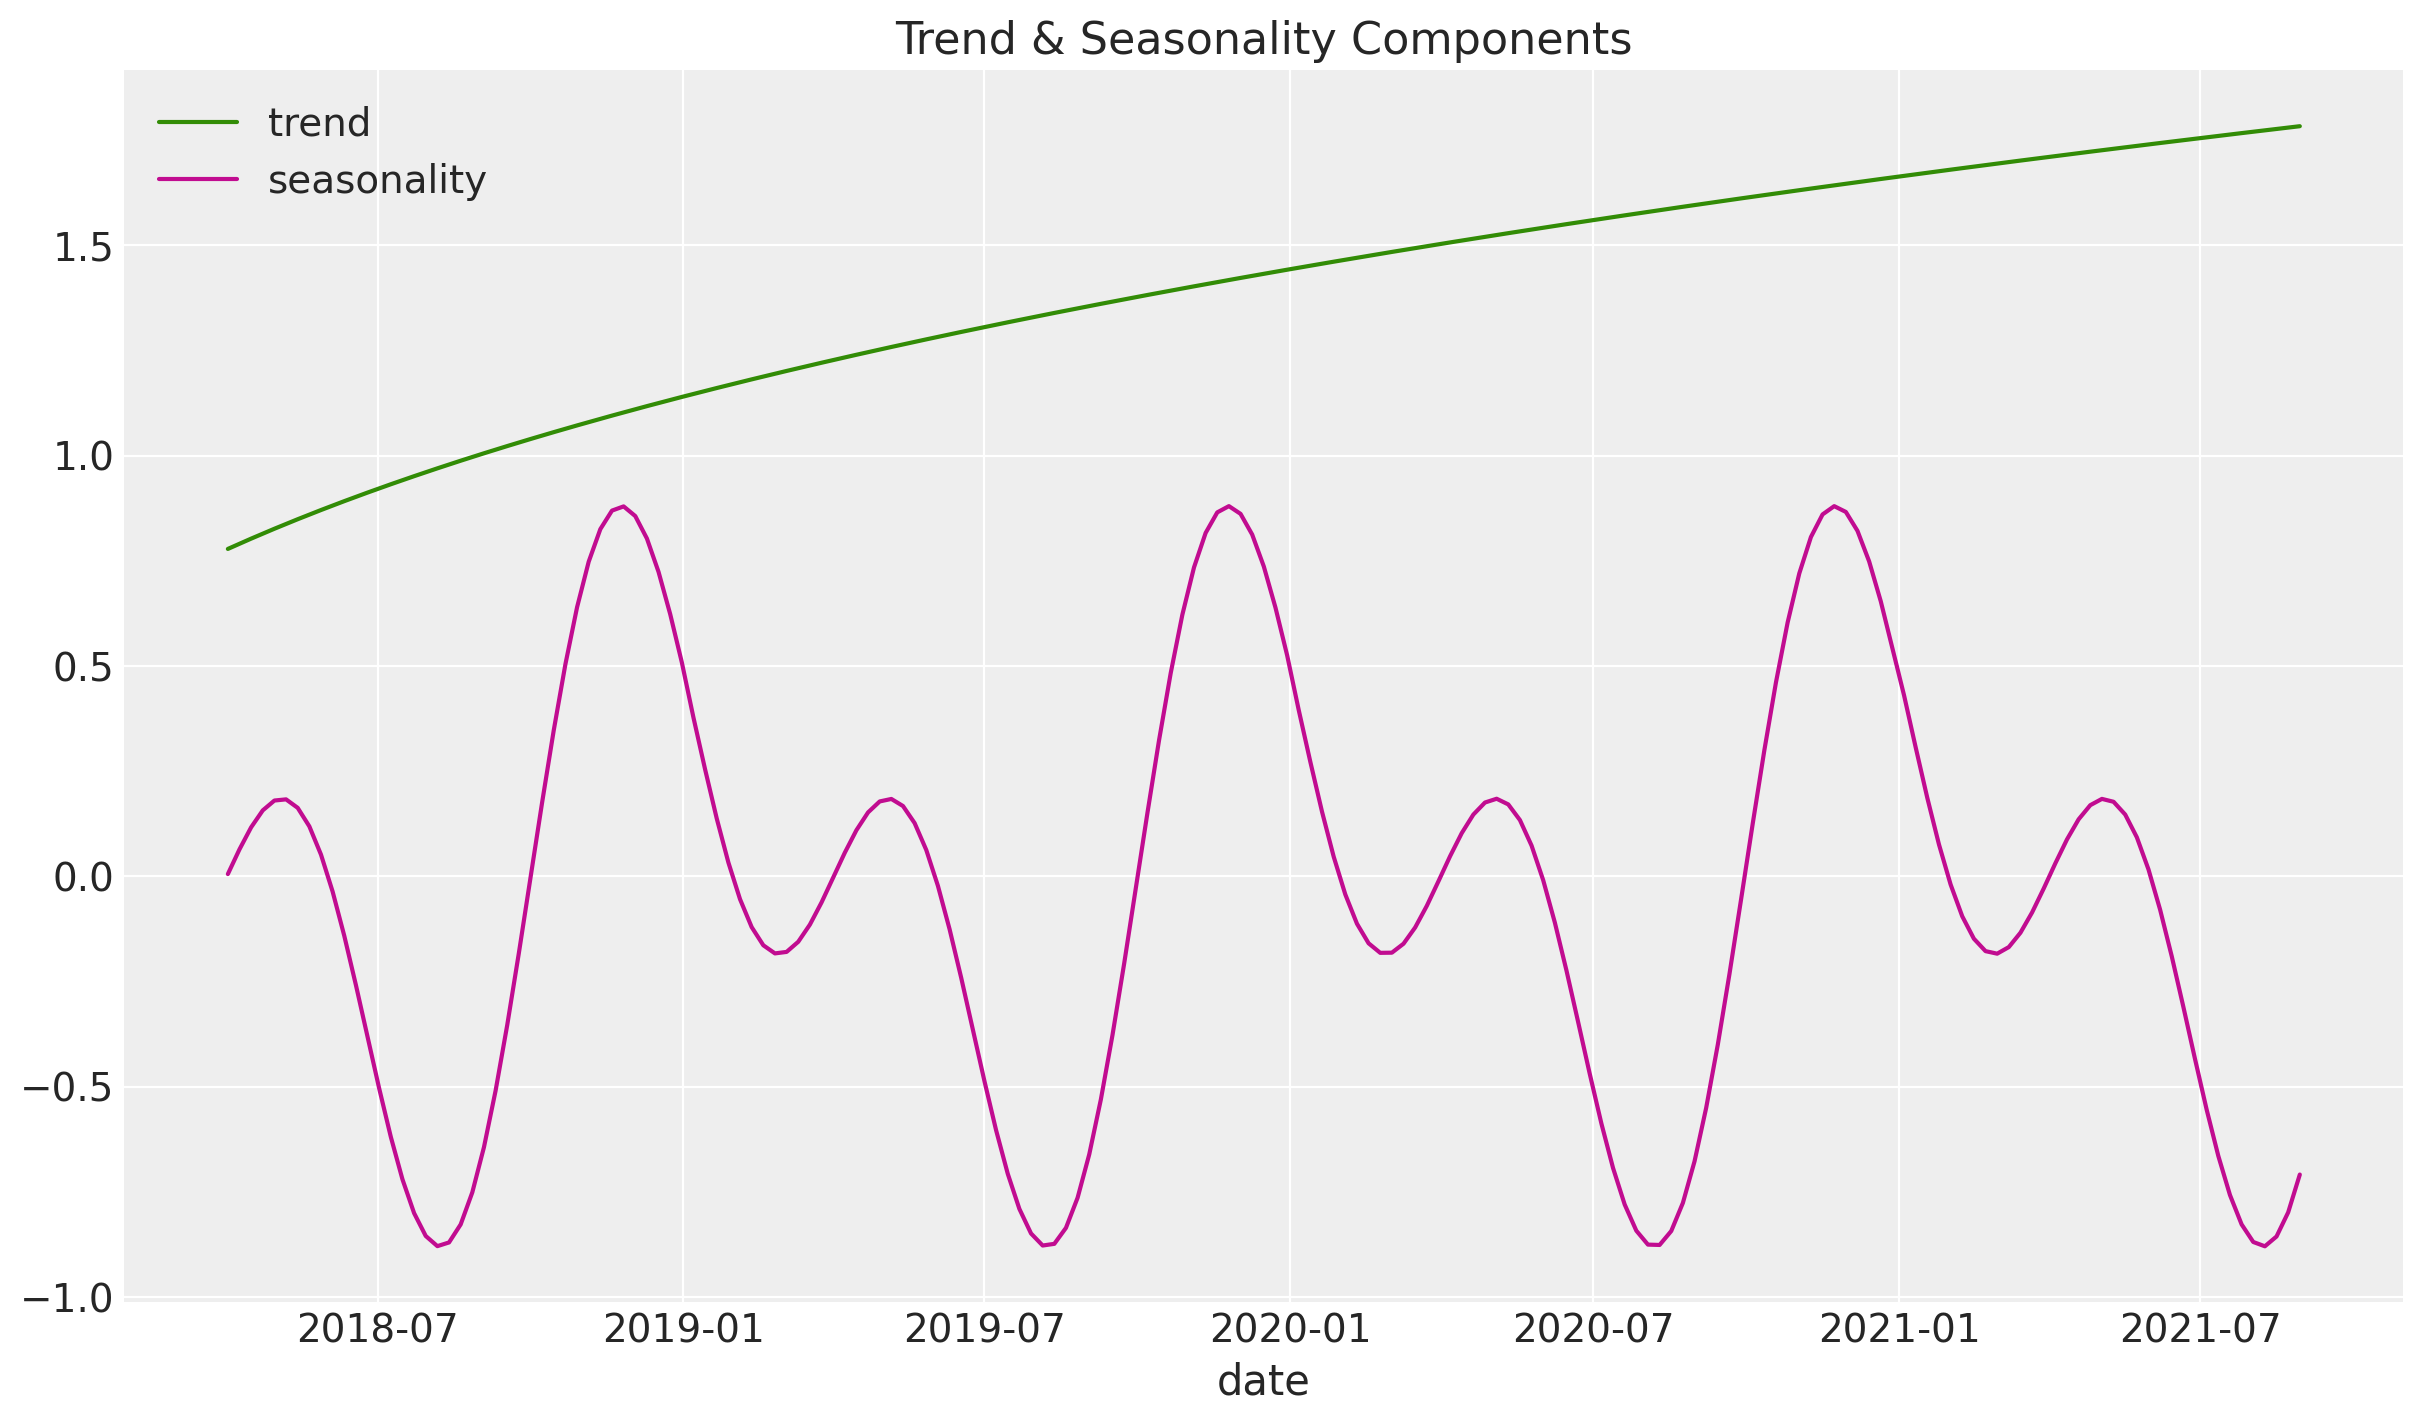

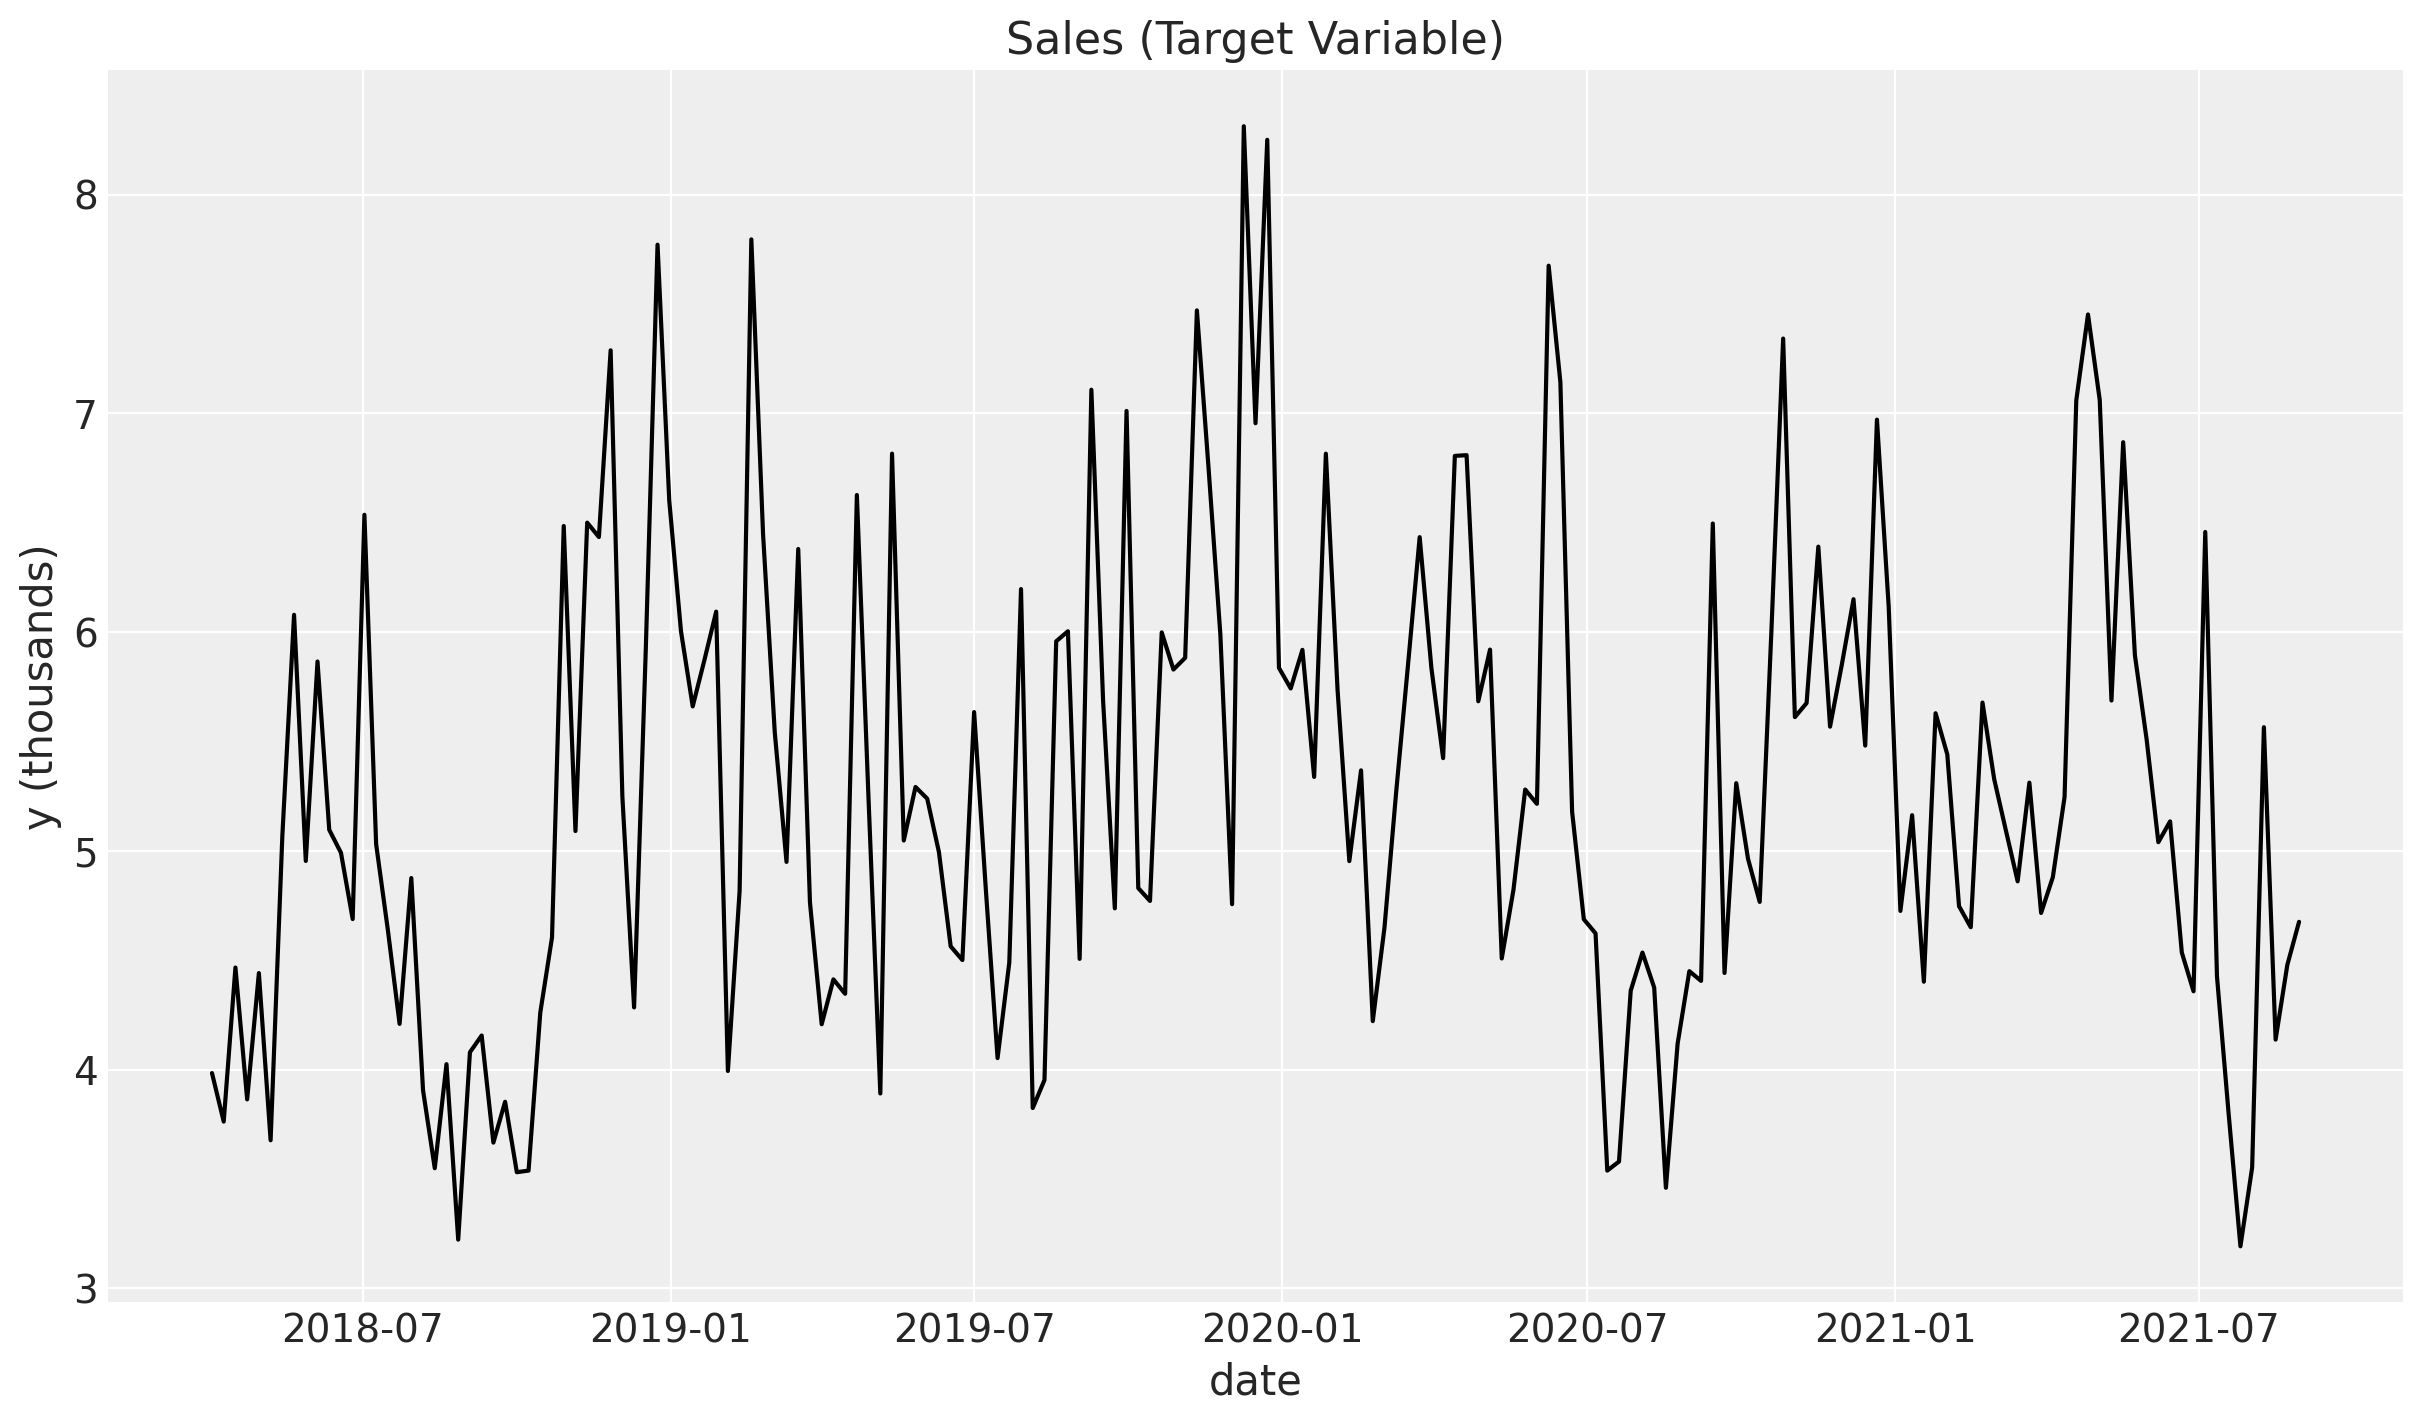

In [3]:
## Generate Data
## We generate data using pymc-marketing's example (https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html)

seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

# date range
min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime("2021-09-01")

df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

n = df.shape[0]
print(f"Number of observations: {n}")

# media data
x1 = rng.uniform(low=0.0, high=1.0, size=n)
df["x1"] = np.where(x1 > 0.9, x1, x1 / 2)

x2 = rng.uniform(low=0.0, high=1.0, size=n)
df["x2"] = np.where(x2 > 0.8, x2, 0)


fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=df, color="C0", ax=ax[0])
sns.lineplot(x="date_week", y="x2", data=df, color="C1", ax=ax[1])
ax[1].set(xlabel="date")
fig.suptitle("Media Costs Data", fontsize=16);

# apply geometric adstock transformation
alpha1: float = 0.4
alpha2: float = 0.2

df["x1_adstock"] = (
    geometric_adstock(x=df["x1"].to_numpy(), alpha=alpha1, l_max=8, normalize=True)
    .eval()
    .flatten()
)

df["x2_adstock"] = (
    geometric_adstock(x=df["x2"].to_numpy(), alpha=alpha2, l_max=8, normalize=True)
    .eval()
    .flatten()
)


# apply saturation transformation
lam1: float = 4.0
lam2: float = 3.0

df["x1_adstock_saturated"] = logistic_saturation(
    x=df["x1_adstock"].to_numpy(), lam=lam1
).eval()

df["x2_adstock_saturated"] = logistic_saturation(
    x=df["x2_adstock"].to_numpy(), lam=lam2
).eval()

fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(16, 9), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date_week", y="x2", data=df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date_week", y="x1_adstock", data=df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date_week", y="x2_adstock", data=df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date_week", y="x1_adstock_saturated", data=df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date_week", y="x2_adstock_saturated", data=df, color="C1", ax=ax[2, 1])
fig.suptitle("Media Costs Data - Transformed", fontsize=16);

# Add trend and seasonality

df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="trend", color="C2", label="trend", data=df, ax=ax)
sns.lineplot(
    x="date_week", y="seasonality", color="C3", label="seasonality", data=df, ax=ax
)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", xlabel="date", ylabel=None);

# add control variables

df["event_1"] = (df["date_week"] == "2019-05-13").astype(float)
df["event_2"] = (df["date_week"] == "2020-09-14").astype(float)


# add target variable

df["intercept"] = 2.0
df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n)

amplitude = 1
beta_1 = 3.0
beta_2 = 2.0
betas = [beta_1, beta_2]


df["y"] = amplitude * (
    df["intercept"]
    + df["trend"]
    + df["seasonality"]
    + 1.5 * df["event_1"]
    + 2.5 * df["event_2"]
    + beta_1 * df["x1_adstock_saturated"]
    + beta_2 * df["x2_adstock_saturated"]
    + df["epsilon"]
)

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="y", color="black", data=df, ax=ax)
ax.set(title="Sales (Target Variable)", xlabel="date", ylabel="y (thousands)");

In [4]:
df.head()

,date_week,year,month,dayofyear,x1,x2,x1_adstock,x2_adstock,x1_adstock_saturated,x2_adstock_saturated,trend,cs,cc,seasonality,event_1,event_2,intercept,epsilon,y
0,2018-04-02,2018,4,92,0.318580,0.0,0.191273,0.0,0.364917,0.0,0.778279,0.021487,-0.010744,0.005371,0.0,0.0,2.0,0.106260,3.984662
1,2018-04-09,2018,4,99,0.112388,0.0,0.143987,0.0,0.280268,0.0,0.790638,0.259165,-0.130704,0.064231,0.0,0.0,2.0,0.067198,3.762872
2,2018-04-16,2018,4,106,0.292400,0.0,0.233150,0.0,0.435205,0.0,0.802746,0.481904,-0.248773,0.116566,0.0,0.0,2.0,0.242042,4.466967
3,2018-04-23,2018,4,113,0.071399,0.0,0.136127,0.0,0.265721,0.0,0.814614,0.676865,-0.363245,0.156810,0.0,0.0,2.0,0.095631,3.864219
4,2018-04-30,2018,4,120,0.386745,0.0,0.286650,0.0,0.517779,0.0,0.826254,0.832810,-0.472462,0.180174,0.0,0.0,2.0,-0.118140,4.441625


In [5]:
# only keep relevant columns

columns_to_keep = [
    "date_week",
    "y",
    "x1",
    "x2",
    "cs",
    "cc",
    "event_1",
    "event_2",
    "dayofyear",
]

data = df[columns_to_keep].copy()

data.head()

,date_week,y,x1,x2,cs,cc,event_1,event_2,dayofyear
0,2018-04-02,3.984662,0.318580,0.0,0.021487,-0.010744,0.0,0.0,92
1,2018-04-09,3.762872,0.112388,0.0,0.259165,-0.130704,0.0,0.0,99
2,2018-04-16,4.466967,0.292400,0.0,0.481904,-0.248773,0.0,0.0,106
3,2018-04-23,3.864219,0.071399,0.0,0.676865,-0.363245,0.0,0.0,113
4,2018-04-30,4.441625,0.386745,0.0,0.832810,-0.472462,0.0,0.0,120


In [6]:
# Feature engineering

# trend feature
data["t"] = range(n)

data.head()


,date_week,y,x1,x2,cs,cc,event_1,event_2,dayofyear,t
0,2018-04-02,3.984662,0.318580,0.0,0.021487,-0.010744,0.0,0.0,92,0
1,2018-04-09,3.762872,0.112388,0.0,0.259165,-0.130704,0.0,0.0,99,1
2,2018-04-16,4.466967,0.292400,0.0,0.481904,-0.248773,0.0,0.0,106,2
3,2018-04-23,3.864219,0.071399,0.0,0.676865,-0.363245,0.0,0.0,113,3
4,2018-04-30,4.441625,0.386745,0.0,0.832810,-0.472462,0.0,0.0,120,4


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     145.0
Date:                Mon, 25 Dec 2023   Prob (F-statistic):           2.74e-54
Time:                        23:39:17   Log-Likelihood:                -137.25
No. Observations:                 179   AIC:                             284.5
Df Residuals:                     174   BIC:                             300.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4672      0.066     67.481      0.0

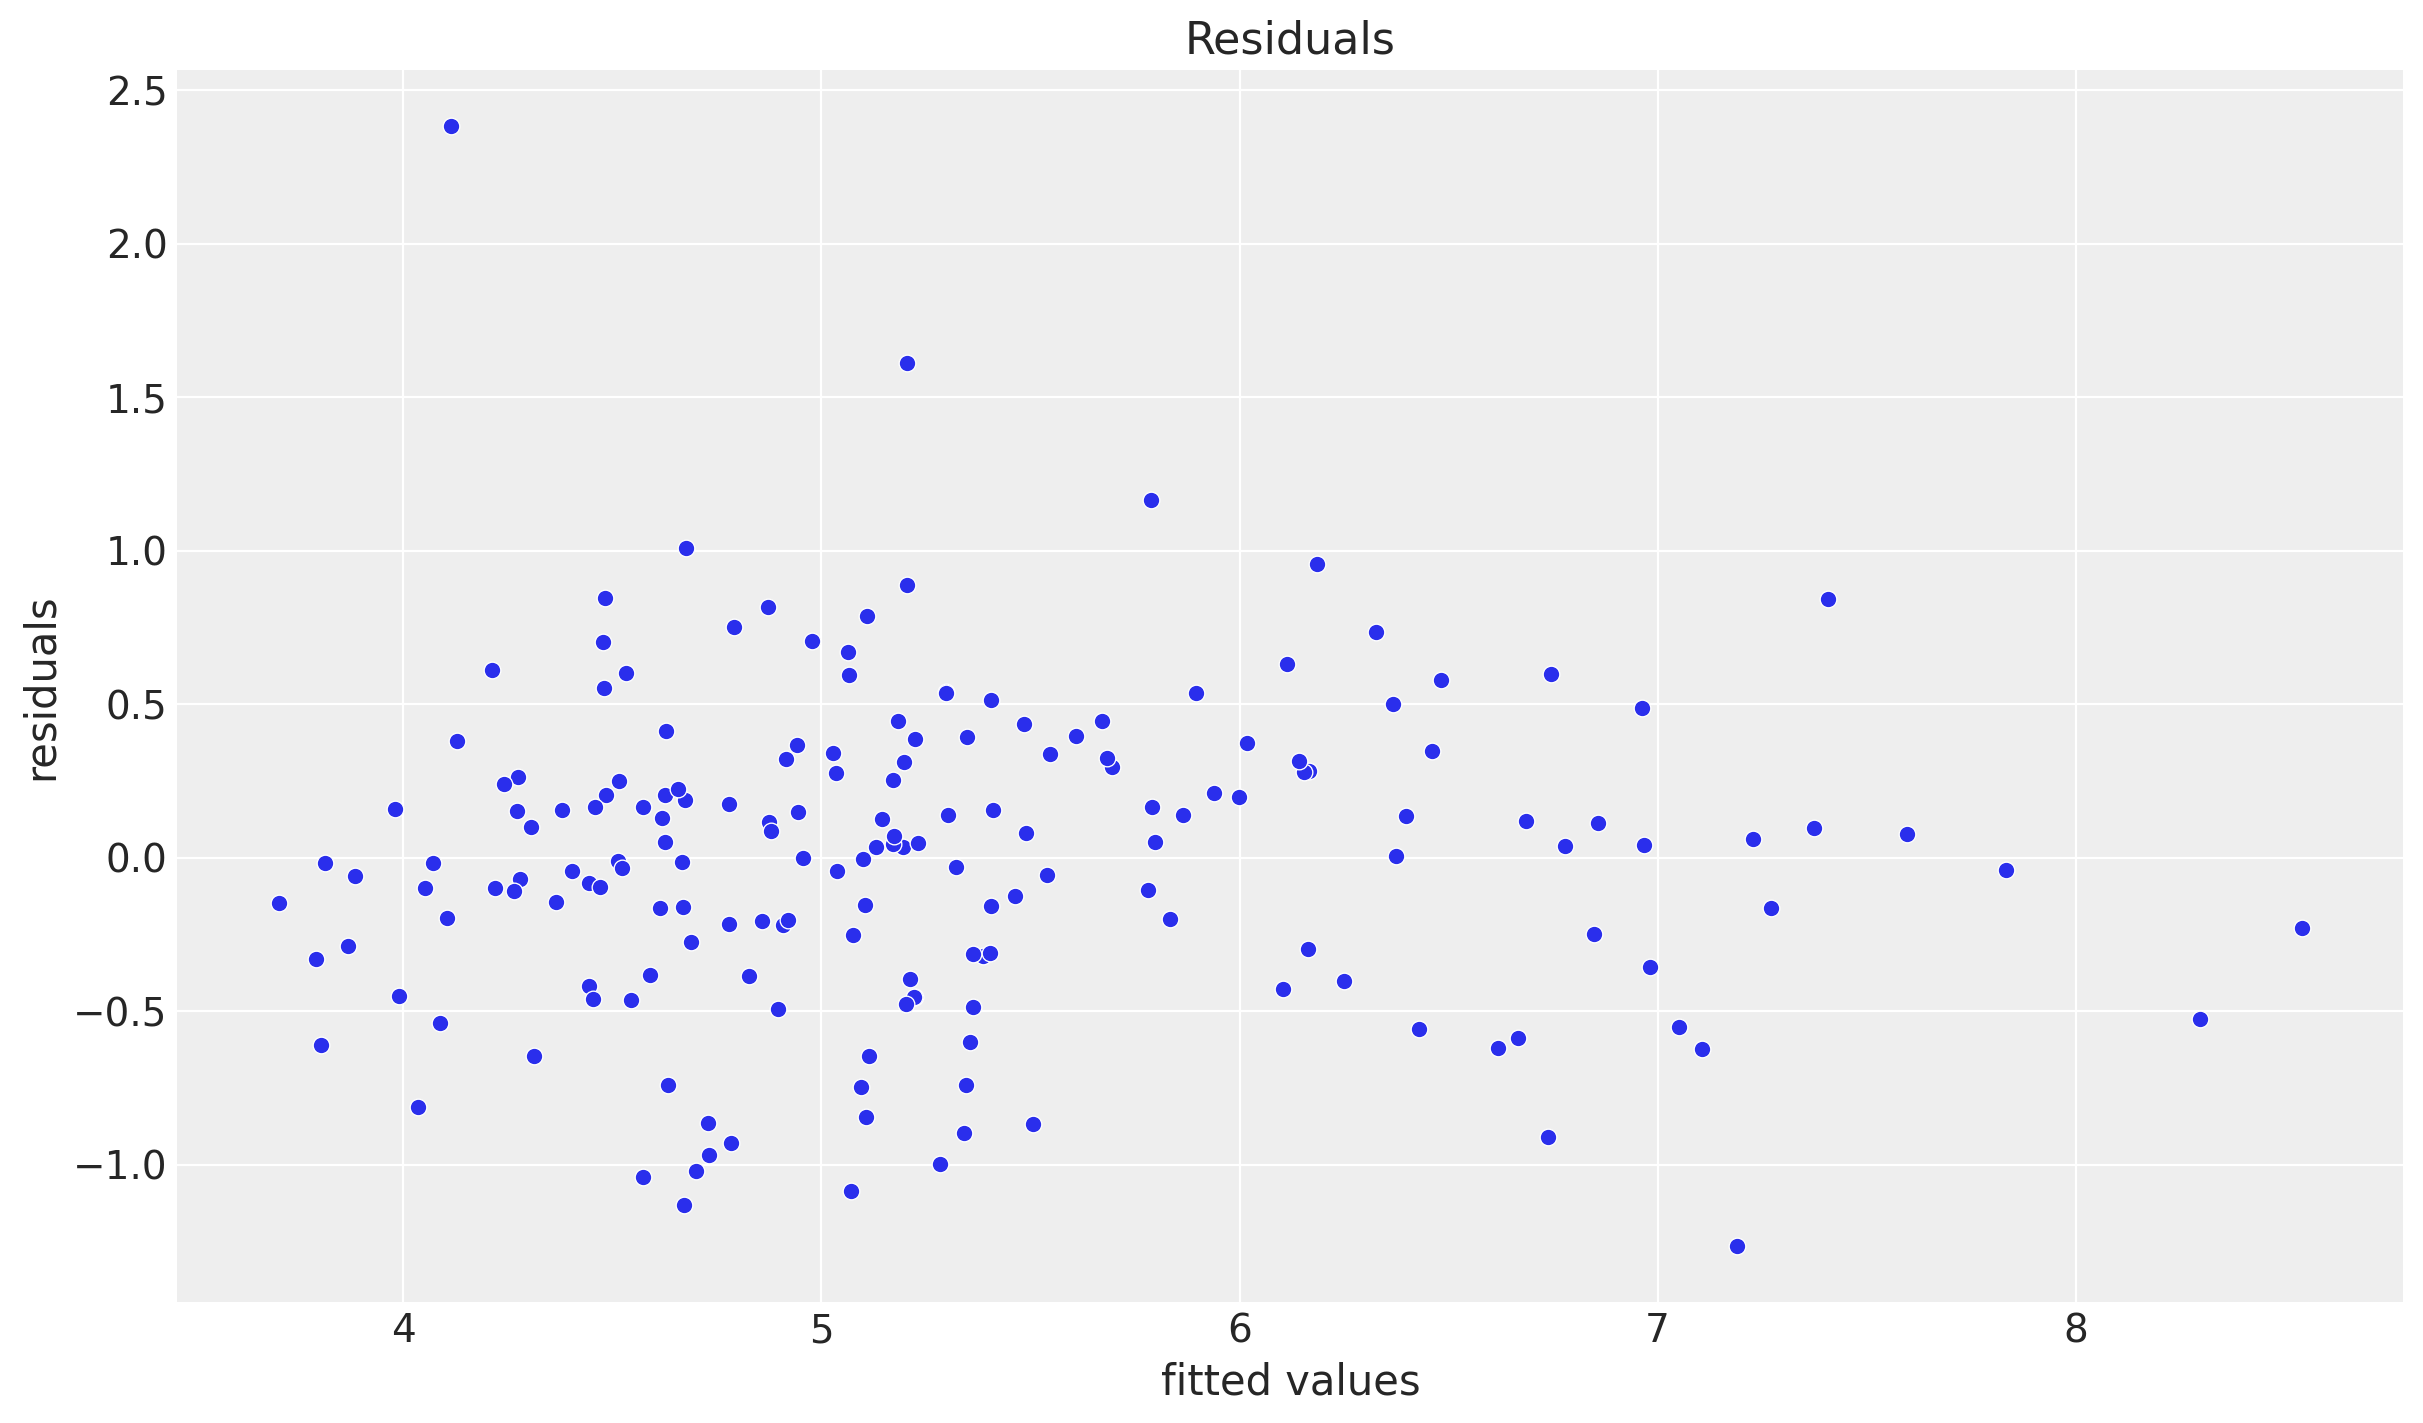

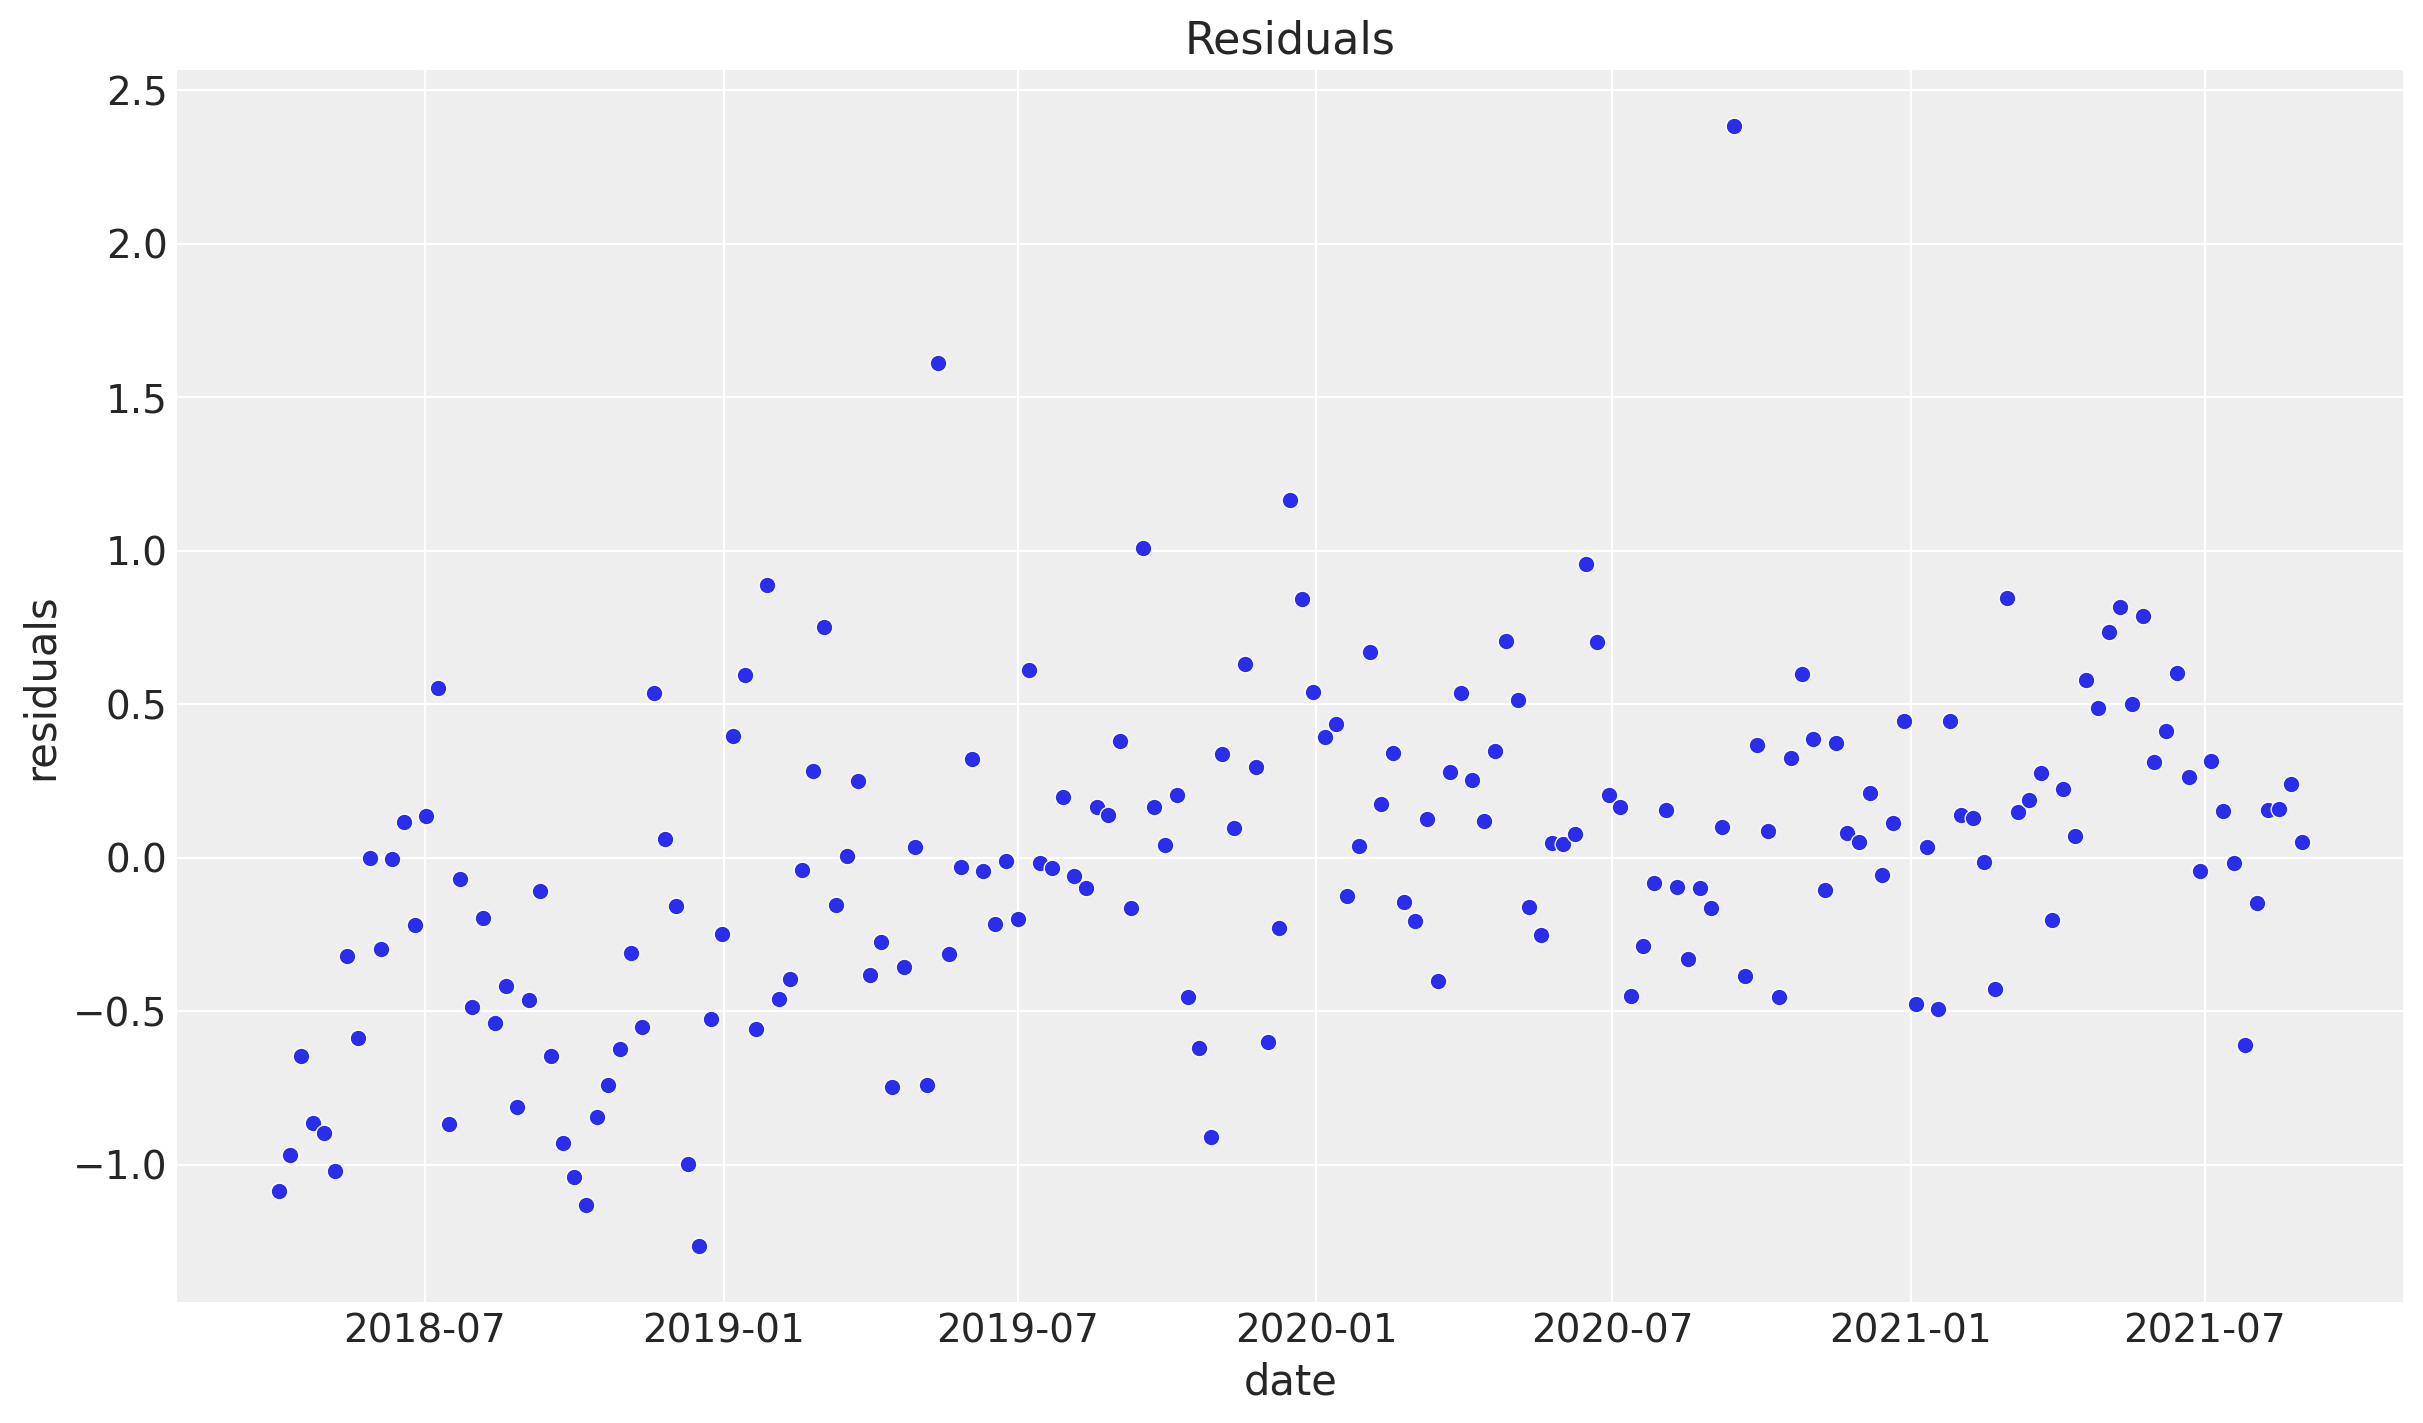

In [7]:
# Simple Linear Regression with statsmodels

X = data[["x1", "x2","cs","cc"]]
X = sm.add_constant(X)
y = data["y"]

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

# plot the residuals

fig, ax = plt.subplots()
sns.scatterplot(x=results.fittedvalues, y=results.resid, ax=ax)
ax.set(title="Residuals", xlabel="fitted values", ylabel="residuals");

# plot the residuals over time

fig, ax = plt.subplots()
sns.scatterplot(x=data["date_week"], y=results.resid, ax=ax)
ax.set(title="Residuals", xlabel="date", ylabel="residuals");


Looking at the residuals, we can see that there is a clear pattern. This is because we have not accounted for the trend in our model.
Also the coefficients from x1 and x2 are: 1.88 and 1.6977 which translates to 53% and 47% (compared to the contribution of 0.81 and 0.19).

# Using pymc-marketing



In [8]:
total_spend_per_channel = data[["x1", "x2"]].sum(axis=0)

spend_share = total_spend_per_channel / total_spend_per_channel.sum()

spend_share

x1    0.65632
x2    0.34368
dtype: float64

In [9]:
# The scale necessary to make a HalfNormal distribution have unit variance
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)

n_channels = 2

prior_sigma = HALFNORMAL_SCALE * n_channels * spend_share.to_numpy()

prior_sigma.tolist()

[2.1775326025486734, 1.1402608773919387]

In [10]:
X = data.drop("y",axis=1)
y = data["y"]

In [11]:
dummy_model = DelayedSaturatedMMM(date_column = "", channel_columns= "", adstock_max_lag = 4)
dummy_model.default_model_config

{'intercept': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'beta_channel': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}},
 'alpha': {'dist': 'Beta', 'kwargs': {'alpha': 1, 'beta': 3}},
 'lam': {'dist': 'Gamma', 'kwargs': {'alpha': 3, 'beta': 1}},
 'likelihood': {'dist': 'Normal',
  'kwargs': {'sigma': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}}}},
 'gamma_control': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'gamma_fourier': {'dist': 'Laplace', 'kwargs': {'mu': 0, 'b': 1}}}

In [12]:
custom_beta_channel_prior = {'beta_channel': {'dist': 'LogNormal',
                                              "kwargs":{"mu":np.array([2,1]), "sigma": prior_sigma},
                                              },
                            "likelihood": {
                                    "dist": "Normal",
                                    "kwargs":{
                                        "sigma": {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}}
                                    # Also possible define sigma as: 
                                    # {'sigma': 5}
                                    }
                                }
                             }
my_model_config = {**dummy_model.default_model_config, **custom_beta_channel_prior}
my_model_config

{'intercept': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'beta_channel': {'dist': 'LogNormal',
  'kwargs': {'mu': array([2, 1]), 'sigma': array([2.1775326 , 1.14026088])}},
 'alpha': {'dist': 'Beta', 'kwargs': {'alpha': 1, 'beta': 3}},
 'lam': {'dist': 'Gamma', 'kwargs': {'alpha': 3, 'beta': 1}},
 'likelihood': {'dist': 'Normal',
  'kwargs': {'sigma': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}}}},
 'gamma_control': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'gamma_fourier': {'dist': 'Laplace', 'kwargs': {'mu': 0, 'b': 1}}}

For the prior specification there is no right or wrong answer. It all depends on the data, the context and the assumptions you are willing to make. It is always recommended to do some prior predictive sampling and sensitivity analysis to check the impact of the priors on the posterior. We skip this here for the sake of simplicity. If you are not sure about specific priors, the DelayedSaturatedMMM class has some default priors that you can use as a starting point.

In [13]:
sampler_config= {"progressbar": True}

In [14]:
mmm = DelayedSaturatedMMM(
    model_config = my_model_config,
    sampler_config = sampler_config,
    date_column="date_week",
    channel_columns=["x1", "x2"],
    control_columns=[
        "event_1",
        "event_2",
        "t",
    ],
    adstock_max_lag=8,
    yearly_seasonality=2,
)

In [16]:
X

,date_week,x1,x2,cs,cc,event_1,event_2,dayofyear,t
0,2018-04-02,0.318580,0.000000,0.021487,-0.010744,0.0,0.0,92,0
1,2018-04-09,0.112388,0.000000,0.259165,-0.130704,0.0,0.0,99,1
2,2018-04-16,0.292400,0.000000,0.481904,-0.248773,0.0,0.0,106,2
3,2018-04-23,0.071399,0.000000,0.676865,-0.363245,0.0,0.0,113,3
4,2018-04-30,0.386745,0.000000,0.832810,-0.472462,0.0,0.0,120,4
...,...,...,...,...,...,...,...,...,...
174,2021-08-02,0.033024,0.000000,-0.879312,-0.859141,0.0,0.0,214,174
175,2021-08-09,0.165615,0.863349,-0.967484,-0.791496,0.0,0.0,221,175
176,2021-08-16,0.171882,0.000000,-0.999887,-0.712405,0.0,0.0,228,176
177,2021-08-23,0.280257,0.000000,-0.974654,-0.623010,0.0,0.0,235,177


In [20]:
mmm.fit(X=X[["date_week","x1","x2","event_1","event_2","t"]], y= y,chains=4, target_accept=0.95, random_seed= rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 